# Решение аналитической задачи на поиск причин переобучения модели

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [14]:
#получим данные
df = pd.read_csv(
    'clicks_dataset_msk_20230101_20230725_spec.csv', 
    names=['request', 'click', 'target'], 
    header=None
    )
df.head(10)

,request,click,target
0,1590973,168299,1
1,1590973,718560,0
2,1234953,325828,1
3,1234953,135968,0
4,3326557,334526,1
5,3326557,541953,0
6,4092778,153837,1
7,4092778,846445,0
8,472877,157611,1
9,472877,405852,0


In [17]:
#чек данные
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12979882 entries, 0 to 12979881
Data columns (total 3 columns):
 #   Column   Non-Null Count     Dtype
---  ------   --------------     -----
 0   request  12979882 non-null  int64
 1   click    12979882 non-null  int64
 2   target   12979882 non-null  int64
dtypes: int64(3)
memory usage: 297.1 MB


In [18]:
#проверим дисбаланс классов и кол-ное распределение на негативы и позитивы
df.target.value_counts()

target
1    6489941
0    6489941
Name: count, dtype: int64

In [20]:
#посмотрим уникальные клики и запросы
print('request - ', len(df.request.unique()), 'click - ', len(df.click.unique()))

request -  4520364 click -  1154540


In [21]:
#посмотрим уникальные клики и запросы у класса 1
print(
    'request - ',
    len(df[df.target == 1].request.unique()), 
    'click - ',
    len(df[df.target == 1].click.unique()),
    )

request -  4520364 click -  1005313


In [22]:
#посмотрим уникальные клики и запросы у класса 0
print(
    'request - ', 
    len(df[df.target == 0].request.unique()), 
    'click - ',
    len(df[df.target == 0].click.unique())
)

request -  4520364 click -  460016


При одинаковом количестве запросов в классе 1 и 0 более чем в 2 раза отличается частота уникальных значение в классах

In [7]:
#проверим уникальные значения кликов топ 10
df.click.value_counts().head(10)

click
135367    2838
161420    2698
128803    2012
91490     1947
356746    1926
82019     1880
623130    1778
76237     1758
392020    1755
130293    1751
Name: count, dtype: int64

In [8]:
#проверим уникальные значения запросов топ 10
df.request.value_counts().head(10)

request
1612834    31864
1863671    28594
2798020    22562
1473816    21864
580239     19684
1269128    19298
2711692    18288
3423161    15314
1912512    14822
3833853    13842
Name: count, dtype: int64

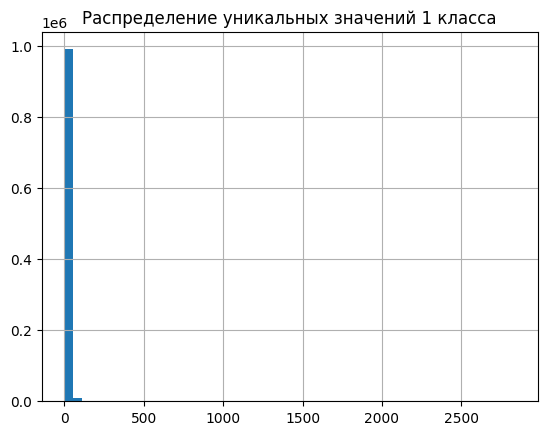

In [24]:
#Проверим распределение уникальных значений в 1 классе
df.loc[df.target == 1, 'click'].value_counts().hist(bins=50)
plt.title('Распределение уникальных значений 1 класса')
plt.show()

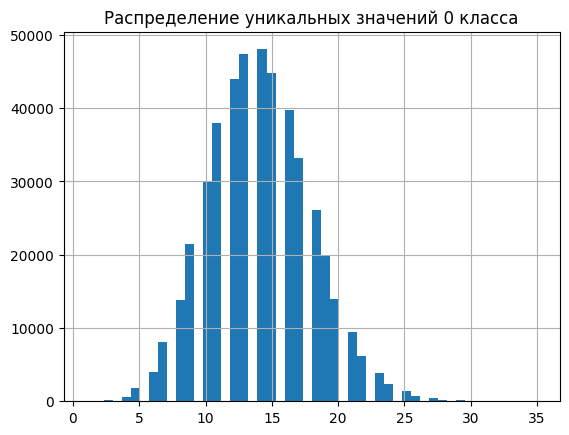

In [25]:
#Проверим распределение уникальных значений в 0 классе
df.loc[df.target == 0, 'click'].value_counts().hist(bins=50)
plt.title('Распределение уникальных значений 0 класса')
plt.show()

Уникальные значения негативов распределены более равномерно в диапазое от 1 до 35, в отличие от позитивов, которые распологаются в диапазоне от 1 до 2838, при чем основное количество в уникальных значениях распределено от 1 до 4.

In [11]:
 #проверим наличие дисбаланса в топ 100 кликов
 for i in df.click.value_counts().head(100).index:
    target_1 = len(df.loc[(df.click == i) & (df.target == 1)])
    target_0 = len(df.loc[(df.click == i) & (df.target == 0)])
    print(f'click {i} target 1 -', target_1)
    print(f'click {i} target 0 -', target_0)
    print(f'click {i} дельта -', target_1 - target_0)
    print('----------------------------------------------')

click 135367 target 1 - 2838
click 135367 target 0 - 0
click 135367 дельта - 2838
----------------------------------------------
click 161420 target 1 - 2698
click 161420 target 0 - 0
click 161420 дельта - 2698
----------------------------------------------
click 128803 target 1 - 1994
click 128803 target 0 - 18
click 128803 дельта - 1976
----------------------------------------------
click 91490 target 1 - 1947
click 91490 target 0 - 0
click 91490 дельта - 1947
----------------------------------------------
click 356746 target 1 - 1926
click 356746 target 0 - 0
click 356746 дельта - 1926
----------------------------------------------
click 82019 target 1 - 1872
click 82019 target 0 - 8
click 82019 дельта - 1864
----------------------------------------------
click 623130 target 1 - 1764
click 623130 target 0 - 14
click 623130 дельта - 1750
----------------------------------------------
click 76237 target 1 - 1747
click 76237 target 0 - 11
click 76237 дельта - 1736
---------------------

Наблюдается явный дисбаланс классов, в примере  на топ 100, но по факту почти во всех значимых уникальных значениях кликов. При таком дисбалансе модель ориентируется на клики и игнорирует реквест.

Проверим эту гипотезу использую простую линейную модель с регляризацией l1

In [30]:
# Разделим данныу на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1), 
    df['target'], 
    test_size=0.2, 
    random_state=42
    )

# Обучение модели логрега c l1 регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)
# Простая оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

# Важность признака с окрглением до 4 знака
model_fi = permutation_importance(model, X_train, y_train)
print(
    'Важность признака request -',
    round(model_fi['importances_mean'][0], 4),
    'Важность признака click -',
    round(model_fi['importances_mean'][1], 4)
    )

Accuracy: 0.6428735693729182

Важность признака request - 0.0 Важность признака click - 0.1431


**Вывод:**  
Основная причина плохой работы модели на реальных данных связана с дисбалансом классов в разрезе уникальных значений клика, что ведет к тому, что значимым для модели признака становится click, но т.к. в внутри уникальных классов явный дисбаланс и при кросс валидации в выборках всегда присутвуют эти дисбалансовые значения, то модель обучаясь запоминает подобную закономерность, а в реальности когда сталкивается с отличным равпределением, совершает ошибку.

Так же на модель скорее всего будет оказывать влияние "простота" негативных примеров, которые не отражают реальные сценарии, пожтому происходть переобучение модели на тестовых данных, и плохая обобщающая способность на реальных данных.

В итоге при текущем датасете модель не учитывает важные факторы, которые влияют на релевантность запроса, что при водит к тому, что модель недоучивается и имеет плохуюобощающую способность на реальных данных.